## Refs 

https://www.tensorflow.org/install

https://www.tensorflow.org/tutorials/keras/classification
    

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape)


(60000, 28, 28, 1)


In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28,1)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 113us/sample - loss: 0.2362 - accuracy: 0.9279 - val_loss: 0.1212 - val_accuracy: 0.9624
Epoch 2/10
48000/48000 [==============================] - 5s 106us/sample - loss: 0.0985 - accuracy: 0.9700 - val_loss: 0.0992 - val_accuracy: 0.9696
Epoch 3/10
48000/48000 [==============================] - 5s 103us/sample - loss: 0.0700 - accuracy: 0.9776 - val_loss: 0.0873 - val_accuracy: 0.9737
Epoch 4/10
48000/48000 [==============================] - 5s 102us/sample - loss: 0.0515 - accuracy: 0.9834 - val_loss: 0.0890 - val_accuracy: 0.9756
Epoch 5/10
48000/48000 [==============================] - 5s 108us/sample - loss: 0.0408 - accuracy: 0.9869 - val_loss: 0.0952 - val_accuracy: 0.9724
Epoch 6/10
48000/48000 [==============================] - 5s 100us/sample - loss: 0.0350 - accuracy: 0.9887 - val_loss: 0.1065 - val_accuracy: 0.9733
Epoch 7/10
48000/48000 [==========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


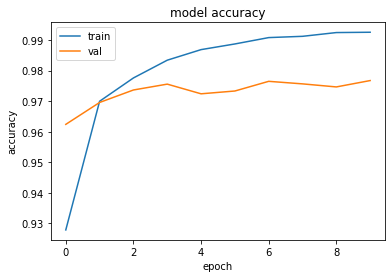

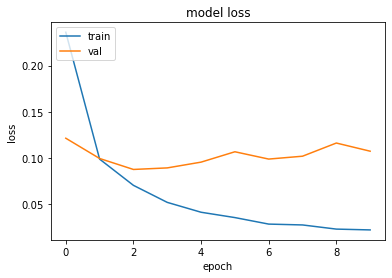

In [6]:
show_history(history)


In [7]:
model.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 1s - loss: 0.1070 - accuracy: 0.9759


[0.10704649504111512, 0.9759]

In [8]:
modelConv = tf.keras.models.Sequential()
modelConv.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:], activation='relu'))
modelConv.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))

modelConv.add(tf.keras.layers.Flatten())

modelConv.add(tf.keras.layers.Dropout(0.5))
modelConv.add(tf.keras.layers.Dense(128, activation='softmax'))

modelConv.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(modelConv.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2359424   
Total params: 2,385,888
Trainable params: 2,385,888
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

history = modelConv.fit(x_train, y_train, 
                        batch_size=32, 
                        epochs=10, 
                        callbacks=[checkpointer],
                        validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47776/48000 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9535
Epoch 00001: val_accuracy improved from -inf to 0.98383, saving model to best_weights.hdf5
48000/48000 [==============================] - 17s 359us/sample - loss: 0.1538 - accuracy: 0.9537 - val_loss: 0.0572 - val_accuracy: 0.9838
Epoch 2/10
47968/48000 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9812
Epoch 00002: val_accuracy improved from 0.98383 to 0.98600, saving model to best_weights.hdf5
48000/48000 [==============================] - 16s 328us/sample - loss: 0.0604 - accuracy: 0.9812 - val_loss: 0.0509 - val_accuracy: 0.9860
Epoch 3/10
47904/48000 [============================>.] - ETA: 0s - loss: 0.0445 - accuracy: 0.9856
Epoch 00003: val_accuracy improved from 0.98600 to 0.98817, saving model to best_weights.hdf5
48000/48000 [==============================] - 16s 323us/sample - loss: 0.0446 - accuracy: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


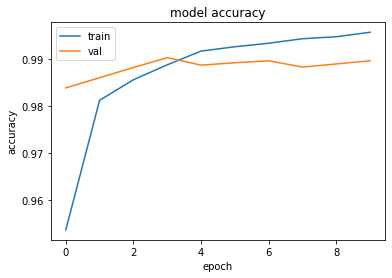

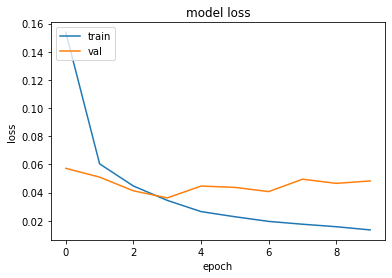

In [10]:
show_history(history)

In [11]:
modelConv.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 2s - loss: 0.0343 - accuracy: 0.9903


[0.034323315829030546, 0.9903]

In [12]:
layer_outputs = [layer.output for layer in modelConv.layers[:2]] # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=modelConv.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [13]:
activations = activation_model.predict(x_test[:1])
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


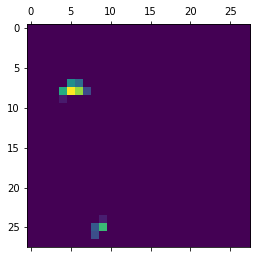

In [14]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

Ref: https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

c:\users\tiagoasfasf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


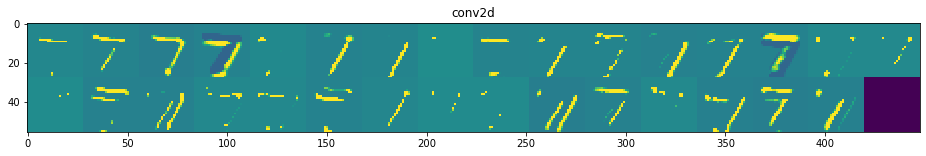

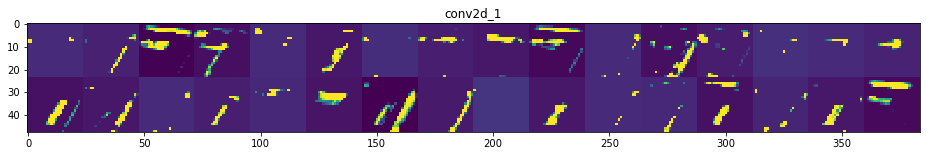

In [15]:
layer_names = []
for layer in modelConv.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
